Training set counts: {'0': 5000, '1': 3803, '2': 5000, '3': 5000, '4': 5000, '5': 5000, '6': 5000, '7': 3750}
Validation set counts: {'0': 100, '1': 100, '2': 100, '3': 100, '4': 100, '5': 100, '6': 100, '7': 100}
Test set counts: {'0': 400, '1': 400, '2': 400, '3': 400, '4': 400, '5': 400, '6': 400, '7': 400}


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=256, out_features=8, bias=True)
)

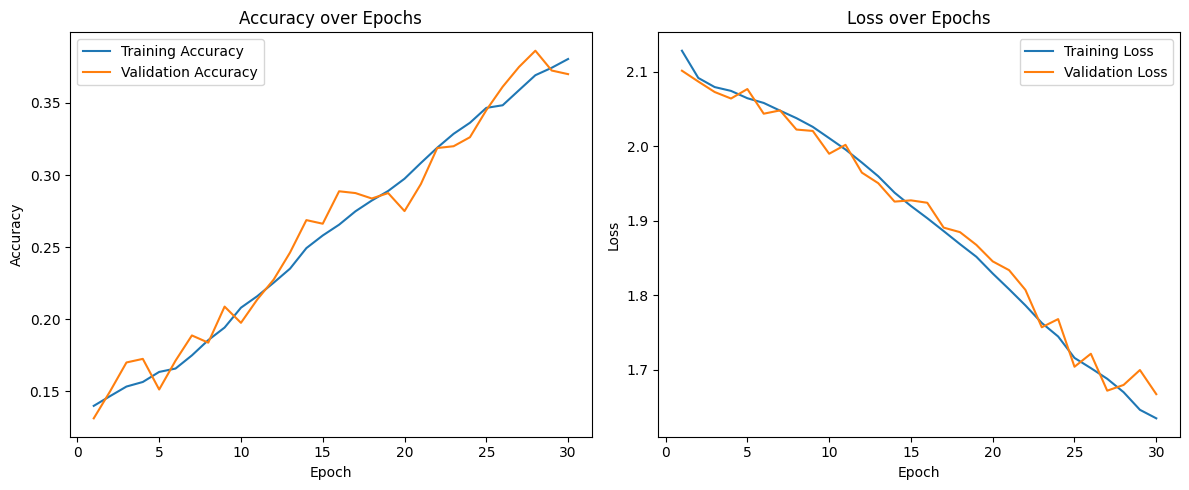

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. Data Inspection and Preprocessing
# -----------------------------
base_dir = "affectnet/AffectNet"  # Root directory for your AffectNet dataset
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

def count_images(directory):
    counts = {}
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            counts[folder] = len(os.listdir(folder_path))
    return counts

print("Training set counts:", count_images(train_dir))
print("Validation set counts:", count_images(val_dir))
print("Test set counts:", count_images(test_dir))

# Image dimensions and hyperparameters
img_size = 224  # Image dimensions (224x224)
batch_size = 32
num_classes = 8

# Define transforms (using data augmentation for training)
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # ImageNet normalization
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=test_val_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# -----------------------------
# 2. Define the Transformer-based Model (Vision Transformer)
# -----------------------------
class PatchEmbedding(nn.Module):
    """
    Divides the image into patches and projects them into a fixed embedding space.
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=256):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        # x: [B, 3, img_size, img_size]
        x = self.proj(x)  # [B, embed_dim, H', W'] where H' = W' = img_size/patch_size
        x = x.flatten(2)  # [B, embed_dim, num_patches]
        x = x.transpose(1, 2)  # [B, num_patches, embed_dim]
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=8,
                 embed_dim=256, depth=6, num_heads=8, mlp_dim=512, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        
        # Learnable [CLS] token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Positional embeddings for patches + cls token
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim,
                                                   nhead=num_heads,
                                                   dim_feedforward=mlp_dim,
                                                   dropout=dropout,
                                                   activation='gelu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.xavier_uniform_(self.head.weight)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)
            
    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # [B, num_patches, embed_dim]
        
        # Concatenate cls token to patch embeddings
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, num_patches+1, embed_dim]
        
        x = x + self.pos_embed  # Add positional embeddings
        x = self.dropout(x)
        
        # Transformer expects shape: (seq_len, batch_size, embed_dim)
        x = x.transpose(0, 1)
        x = self.transformer(x)
        x = x.transpose(0, 1)
        
        # Take the [CLS] token representation and apply normalization and classification head
        cls_out = self.norm(x[:, 0])
        logits = self.head(cls_out)
        return logits

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(img_size=img_size, patch_size=16, in_channels=3, num_classes=num_classes,
                          embed_dim=256, depth=6, num_heads=8, mlp_dim=512, dropout=0.1).to(device)
print(model)

# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 30

# For tracking best model
best_val_acc = 0.0
best_model_path = "best_emotion_transformer_weights.pth"

# Lists for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# -----------------------------
# 4. Training Loop
# -----------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)
            
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")
    
    # Save best model weights based on validation accuracy
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model.state_dict(), best_model_path)

# Save final model weights
final_model_path = "final_emotion_transformer_weights.pth"
torch.save(model.state_dict(), final_model_path)
print("Model training complete. Best weights saved at:", best_model_path)
print("Final model weights saved at:", final_model_path)

# -----------------------------
# 5. Evaluation on Test Set
# -----------------------------
model.eval()
test_running_loss = 0.0
test_running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_running_corrects += torch.sum(preds == labels.data)
        
test_loss = test_running_loss / len(test_dataset)
test_acc = test_running_corrects.double() / len(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# -----------------------------
# 6. Visualizations: Loss and Accuracy Curves
# -----------------------------
epochs_range = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
